<a href="https://colab.research.google.com/github/paulet-art/cema-submission/blob/main/malariaclassificationmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **MALARIA CLASSIFICATION MODEL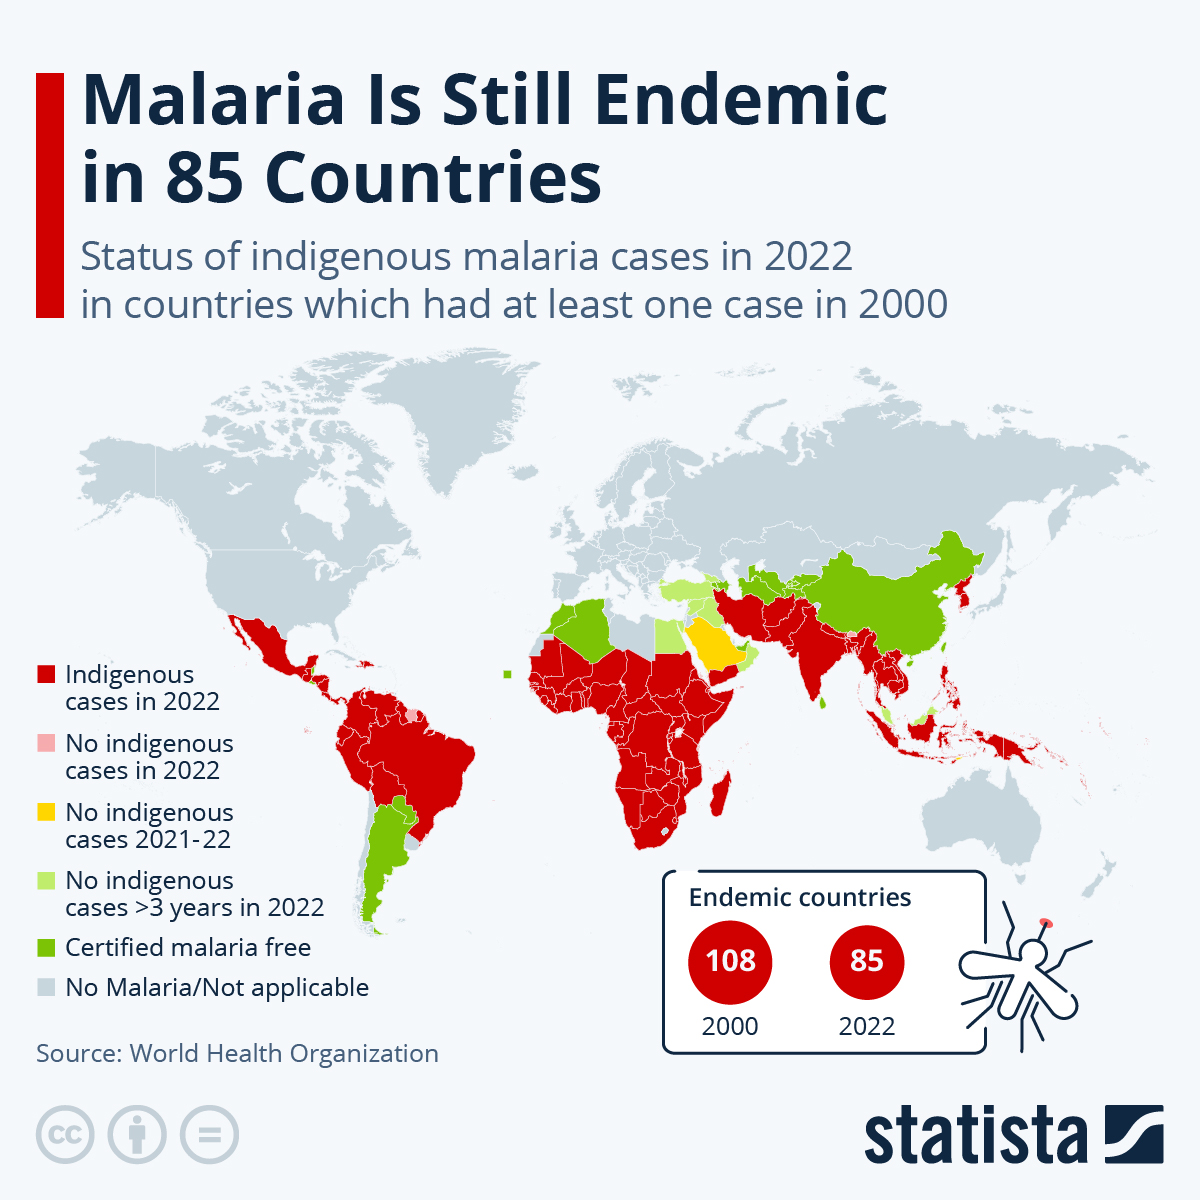**

# Summary and Highlights

- **Model Development**: Developed a deep learning model using TensorFlow and Keras for malaria classification.
- **Dataset Description**: Utilized a dataset comprising thin blood smear images of segmented cells, evenly distributed between parasitized and uninfected cells.
- **Data Preprocessing**: Applied preprocessing steps such as normalization and resizing to prepare the dataset for model training.
- **Model Architecture**: Constructed a convolutional neural network (CNN) architecture consisting of convolutional and dense layers.
- **Training Process**: Trained the model using binary cross-entropy loss and Adam optimizer to differentiate between parasitized and uninfected cells.
- **Callback Implementation**: Implemented callbacks such as learning rate scheduling, model checkpointing, and early stopping to enhance training efficiency and save the best weights.
- **Model Evaluation**: Evaluated the model's performance using the receiver operating characteristic (ROC) curve, assessing the area under the curve (AUC) as a metric of classification accuracy.
- **Model Saving**: Saved the trained model and its best weights for future use.
- **Endemic Nature of Malaria**: Malaria is endemic in many regions due to factors such as favorable climate conditions for mosquito vectors, inadequate healthcare infrastructure, lack of access to preventive measures like insecticide-treated bed nets, and limited availability of effective treatments and vaccines. Additionally, socio-economic factors, population movement, and environmental changes contribute to the persistence of malaria in endemic areas.

# Environment setup , Data Loading and Exploration

To set up the data environment, TensorFlow Datasets (TFDS) was employed to load the malaria dataset, encompassing segmented cell images from thin blood smears. The dataset, evenly balanced between parasitized and uninfected cells, was divided into training and testing splits to facilitate model development and evaluation.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve
import numpy as np

In [ ]:
train_ds, test_ds = tfds.load(
    'malaria',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    )

In [ ]:
ds, ds_info = tfds.load(
    'malaria',
    with_info=True
)

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

### Data Exploration

In the data exploration phase, I examined the classes and their distribution within the malaria dataset, revealing two classes: parasitized and uninfected cells. Additionally, I inspected the number of instances in each class and observed varying image shapes among the dataset samples.

In [ ]:
print('Number of Classes :' + str(ds_info.features['label'].num_classes))

Number of Classes :2


In [ ]:
print('Label names : ' + str(ds_info.features['label'].names))

Label names : ['parasitized', 'uninfected']


In [ ]:

number_of_train_images = tf.data.experimental.cardinality(train_ds).numpy()
print("NUMBER OF TRAINING IMAGES: ", str(number_of_train_images))

NUMBER OF TRAINING IMAGES:  19291


In [ ]:
number_of_test_images = tf.data.experimental.cardinality(test_ds).numpy()
print("NUMBER OF TEST IMAGES :", str(number_of_test_images))

NUMBER OF TEST IMAGES : 4134


In [ ]:
for image, label in train_ds.take(5):
  print("Image shape :", image.numpy().shape)
  print("Label name :", label.numpy())


Image shape : (103, 103, 3)
Label name : 0
Image shape : (115, 157, 3)
Label name : 0
Image shape : (136, 127, 3)
Label name : 0
Image shape : (166, 139, 3)
Label name : 0
Image shape : (148, 133, 3)
Label name : 0


### Data Preparation

In the data preparation section, I performed preprocessing steps on the malaria dataset to prepare it for model training. This included resizing images to a uniform size of 32x32 pixels and normalizing pixel values to the range [0, 1]. Additionally, I cached, batched, and prefetched the training and testing datasets to optimize performance during model training and evaluation.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
IMAGE_SIZE = [32,32]

In [ ]:
def resize_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE)
  return image, label

In [ ]:
def normalize_dtype(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
  return image, label

In [ ]:
train_ds = train_ds.map(normalize_dtype, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(resize_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(AUTOTUNE)

In [ ]:
test_ds = test_ds.map(normalize_dtype, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(resize_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache()
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(AUTOTUNE)

In [ ]:
model = keras.models.load_model("malaria_classification_model/")

# Model Building

In [336]:
models = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 3)),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32 ,3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ]
)


In [337]:
print(models.summary())

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_132 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_18 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_133 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_19 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                     

Given that our task involves binary classification, our choice of loss function is binary crossentropy. Notably, our dataset is evenly distributed, with an equal number of parasitized and uninfected images. This balance allows us to utilize the AUC-ROC metric, which assesses the model's performance across various thresholds and is well-suited for evaluating binary classification tasks on balanced datasets.

In [338]:
models.compile(
    loss = keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer = keras.optimizers.Adam(learning_rate=3e-4),
    metrics = tf.keras.metrics.AUC(name='auc')
)

In [339]:

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

### Model training

In [344]:
models.fit(
    train_ds,
    epochs=10,
    callbacks=[lr_scheduler],
    verbose=2
)

Epoch 1/10
345/345 - 90s - loss: 0.5531 - auc: 0.7707 - lr: 0.0100 - 90s/epoch - 261ms/step
Epoch 2/10
345/345 - 89s - loss: 0.4004 - auc: 0.8973 - lr: 0.0089 - 89s/epoch - 259ms/step
Epoch 3/10
345/345 - 89s - loss: 0.3305 - auc: 0.9319 - lr: 0.0079 - 89s/epoch - 257ms/step
Epoch 4/10
345/345 - 89s - loss: 0.2565 - auc: 0.9621 - lr: 0.0071 - 89s/epoch - 257ms/step
Epoch 5/10
345/345 - 89s - loss: 0.2087 - auc: 0.9742 - lr: 0.0063 - 89s/epoch - 259ms/step
Epoch 6/10
345/345 - 104s - loss: 0.1806 - auc: 0.9799 - lr: 0.0056 - 104s/epoch - 301ms/step
Epoch 7/10
345/345 - 95s - loss: 0.1600 - auc: 0.9838 - lr: 0.0050 - 95s/epoch - 274ms/step
Epoch 8/10
345/345 - 110s - loss: 0.1487 - auc: 0.9854 - lr: 0.0045 - 110s/epoch - 319ms/step
Epoch 9/10
345/345 - 88s - loss: 0.1408 - auc: 0.9869 - lr: 0.0040 - 88s/epoch - 256ms/step
Epoch 10/10
345/345 - 90s - loss: 0.1349 - auc: 0.9880 - lr: 0.0035 - 90s/epoch - 260ms/step


### Model evaluation on test data

In [345]:
models.evaluate(
    test_ds,
    verbose=2
)

87/87 - 9s - loss: 0.2889 - auc: 0.9786 - 9s/epoch - 98ms/step


[0.28892824053764343, 0.9786477088928223]

### Evaluation Metric

In [346]:
y_pred_prob = models.predict(test_ds)

87/87 [==============================] - 5s 54ms/step


In [347]:
y_true = np.concatenate([y for _, y in test_ds], axis=0)

In [348]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

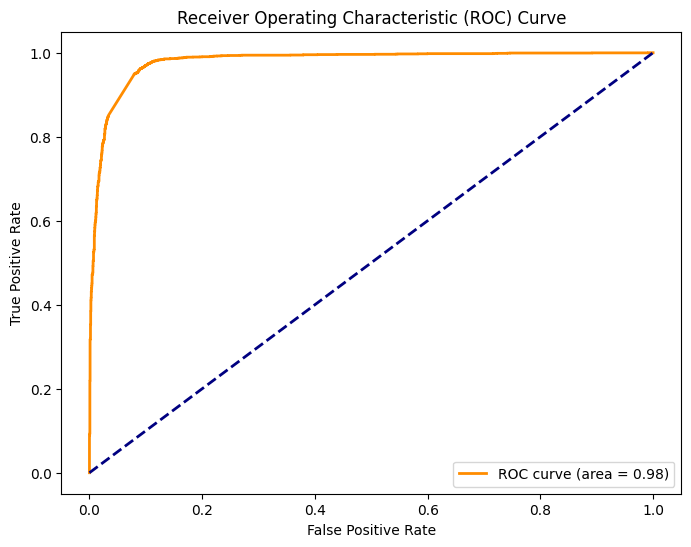

In [349]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Model loading

In [350]:
models.save("malaria_classification_model/")

# Model Explanation and Training Process

#### Model Architecture
The model uses layers designed to understand and classify images.

#### Training Process Steps
 **Model Training**: The model learns from the training data over multiple rounds. Running at 10 epochs. Training for a larger set of parameters over a longer time can yield as better results by identifying more patterns.

#### Challenges Faced
1. **Finding the Right Setup**: Deciding how many layers to use and how they should be connected was tricky. It required testing different setups to see what worked best.
2. **Avoiding Overthinking**: Too much complexity in the model could make it harder to learn. It was important to strike a balance between a simple model and one that could understand the data well.
3. **Adjusting Parameters**: Small changes in settings, like how fast the model learns or how much it should pay attention to certain patterns, could have big effects on performance. It took some trial and error to find the best settings.

In the end, simplicity often led to better results, showing that sometimes, simpler models can be more effective at understanding complex data.
